In [1]:
# Compatibility layer between Python 2 and Python 3
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import np_utils

Using TensorFlow backend.


In [10]:
# %%

def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma


def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


def show_basic_dataframe_info(dataframe,
                              preview_rows=20):

    """
    This function shows basic information for the given dataframe

    Args:
        dataframe: A Pandas DataFrame expected to contain data
        preview_rows: An integer value of how many rows to preview

    Returns:
        Nothing
    """

    # Shape and how many rows and columns
    print("Number of columns in the dataframe: %i" % (dataframe.shape[1]))
    print("Number of rows in the dataframe: %i\n" % (dataframe.shape[0]))
    print("First 20 rows of the dataframe:\n")
    # Show first 20 rows
    print(dataframe.head(preview_rows))
    print("\nDescription of dataframe:\n")
    # Describe dataset like mean, min, max, etc.
    # print(dataframe.describe())


def read_data(file_path):

    df = pd.read_csv(file_path, float_precision='round_trip')
    return df


def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan


# Not used right now
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma


def plot_axis(ax, x, y, title):

    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['time'], data['I'], 'Lead I')
    plot_axis(ax1, data['time'], data['II'], 'Lead II')
    plot_axis(ax2, data['time'], data['III'], 'Lead III')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()


def create_segments_and_labels(df, time_steps, step, label_name):

    """
    This function receives a dataframe and returns the reshaped segments
    of x,y,z acceleration as well as the corresponding labels

    Args:
        df: Dataframe in the expected format
        time_steps: Integer value of the length of a segment that is created
    Returns:
        reshaped_segments
        labels:
    """

    # x, y, z acceleration as features
    N_FEATURES = 1
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['II'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

keras version  2.3.1

--- Load, inspect and transform data ---

Number of columns in the dataframe: 15
Number of rows in the dataframe: 87040

First 20 rows of the dataframe:

    id label        time      I     II    III    AVR    AVL    AVF     V1  \
0    1     N  '0:00.284'  3.657  2.026  0.366 -2.977  1.124  1.186 -3.722   
1    1     N  '0:00.288'  3.712  2.170  0.454 -3.075  1.108  1.304 -3.758   
2    1     N  '0:00.292'  3.758  2.268  0.507 -3.147  1.105  1.379 -3.820   
3    1     N  '0:00.296'  3.739  2.288  0.546 -3.147  1.075  1.408 -3.827   
4    1     N  '0:00.300'  3.663  2.141  0.474 -3.036  1.072  1.297 -3.761   
5    1     N  '0:00.304'  3.699  1.977  0.275 -2.974  1.190  1.118 -3.735   
6    1     N  '0:00.307'  3.758  1.886  0.124 -2.958  1.294  0.997 -3.719   
7    1     N  '0:00.311'  3.690  1.814  0.121 -2.886  1.261  0.958 -3.680   
8    1     N  '0:00.315'  3.716  1.765  0.046 -2.876  1.314  0.895 -3.680   
9    1     N  '0:00.319'  3.879  1.768 -0.114 -2.958  

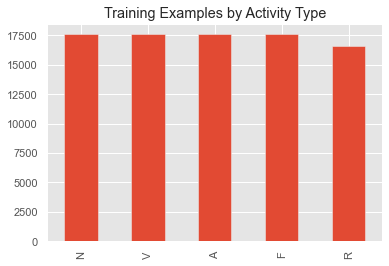

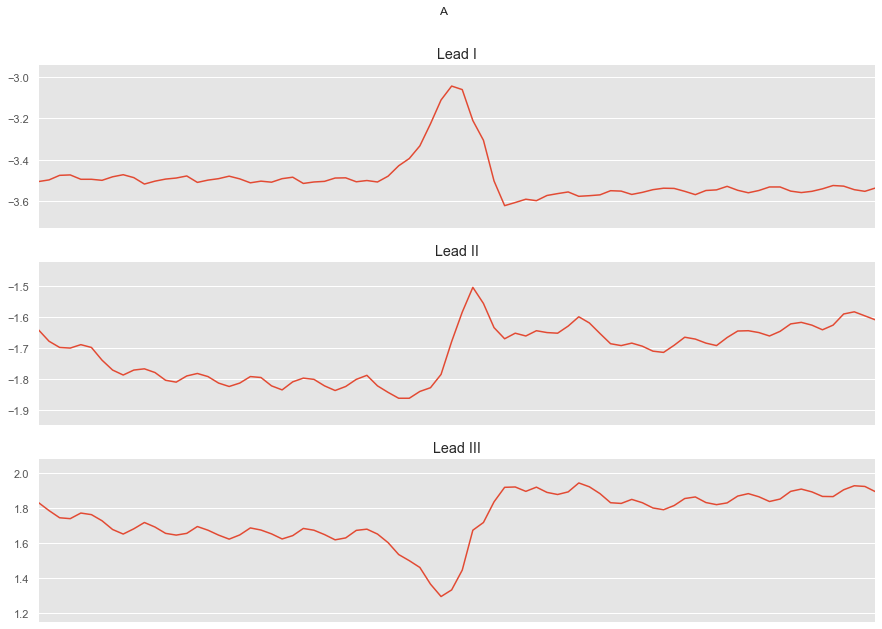

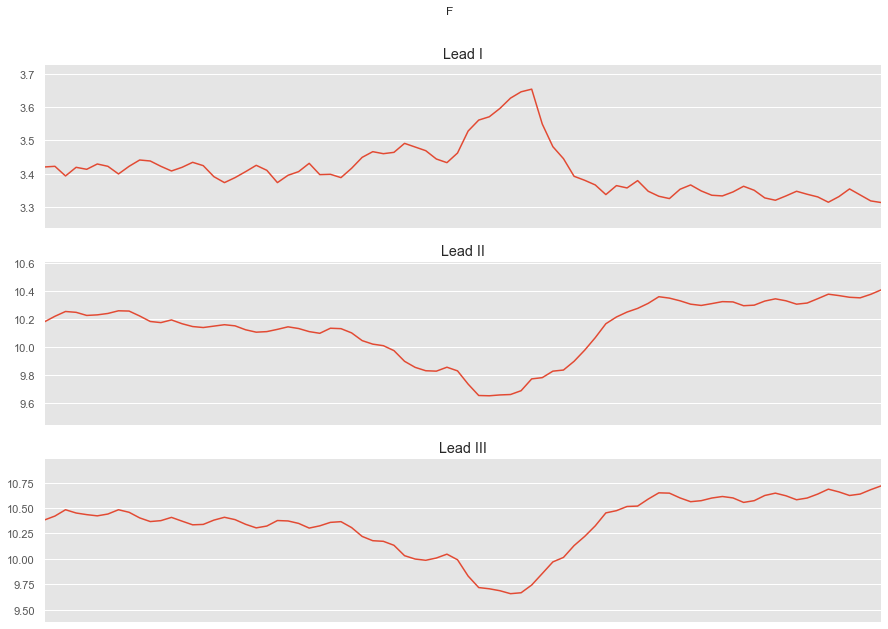

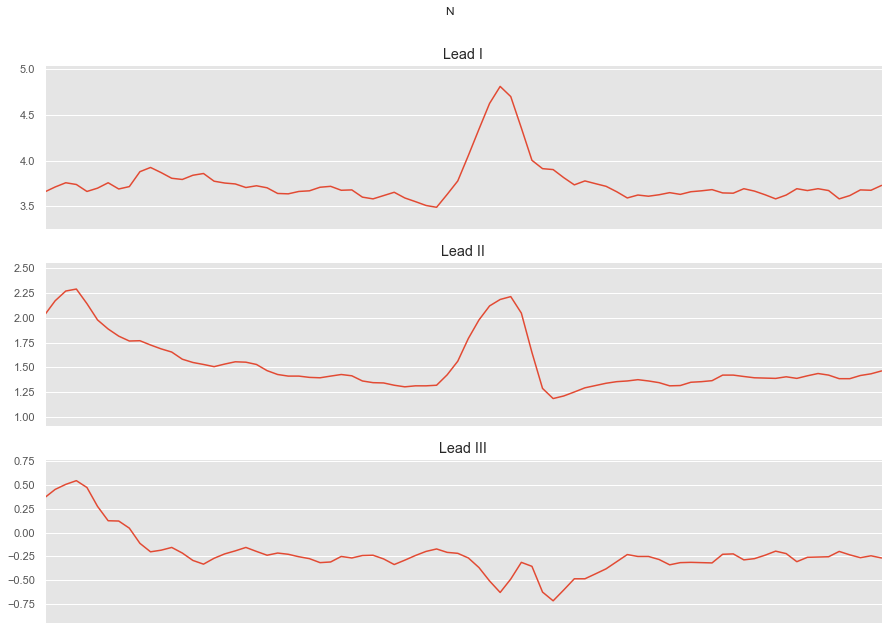

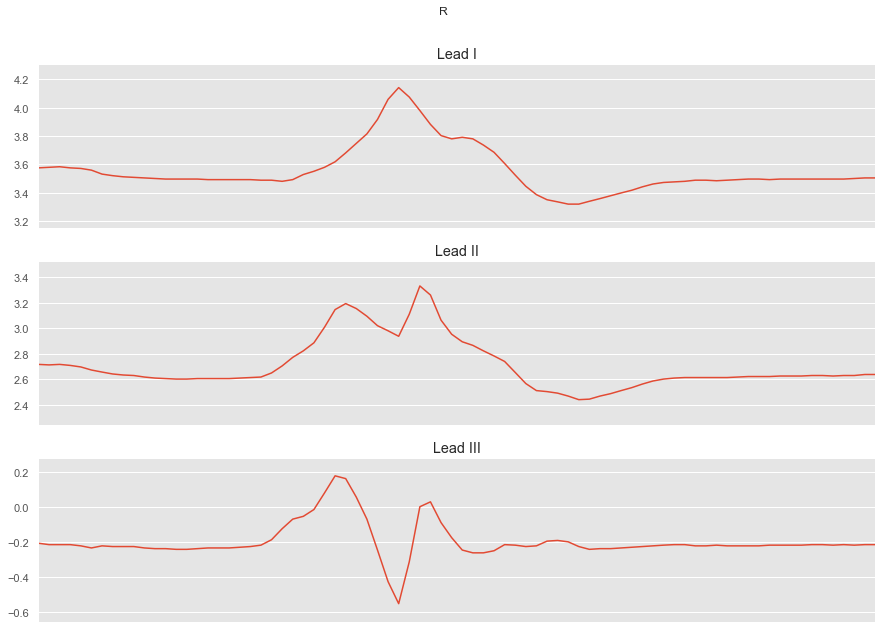

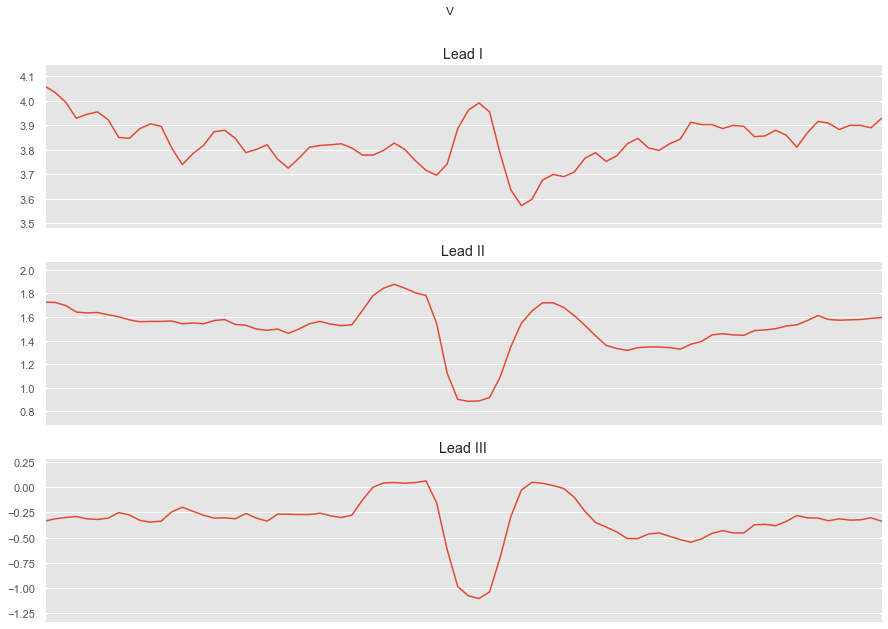

In [11]:
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', keras.__version__)

LABELS = ["N",
          "V",
          "R",
          "A",
          "F"]
# The number of steps within one time segment
TIME_PERIODS = 80
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 80

# %%

print("\n--- Load, inspect and transform data ---\n")

# Load data set containing all the data from csv
df = read_data('db_baru.csv')

# Describe the data
show_basic_dataframe_info(df, 20)

df['label'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()

for activity in np.unique(df["label"]):
    subset = df[df["label"] == activity][:80]
    plot_activity(activity, subset)

# Define column name of the label vector
LABEL = "ActivityEncoded"
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df["label"].values.ravel())

In [16]:
print("\n--- Reshape the data into segments ---\n")

# Differentiate between test set and training set
df_test = df[df['id'] > 1000]
df_train = df[df['id'] <= 1000]

# Normalize features for training data set
df_train['II'] = feature_normalize(df['II'])
# Round in order to comply to NSNumber from iOS
df_train = df_train.round({'II': 6})

# Reshape the training data into segments
# so that they can be processed by the network
x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

# %%

print("\n--- Reshape data to be accepted by Keras ---\n")

# Inspect x data
print('x_train shape: ', x_train.shape)
# Displays (20869, 40, 3)
print(x_train.shape[0], 'training samples')
# Displays 20869 train samples

# Inspect y data
print('y_train shape: ', y_train.shape)
# Displays (20869,)

print(x_train)
print(y_train)

# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

# Set input_shape / reshape for Keras
# Remark: acceleration data is concatenated in one array in order to feed
# it properly into coreml later, the preferred matrix of shape [40,3]
# cannot be read in with the current version of coreml (see also reshape
# layer as the first layer in the keras model)
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)

print('x_train shape:', x_train.shape)
# x_train shape: (20869, 120)
print('input_shape:', input_shape)
# input_shape: (120)

# Convert type for Keras otherwise Keras cannot process the data
x_train = x_train.astype("float32")
y_train = y_train.astype("float32")

# %%

# One-hot encoding of y_train labels (only execute once!)
y_train = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train.shape)
# (4173, 6)
print(x_train)
print(y_train)




--- Reshape the data into segments ---



C:\Users\62812\.conda\envs\tugasakhir_env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  



--- Reshape data to be accepted by Keras ---

x_train shape:  (999, 80, 1)
999 training samples
y_train shape:  (999,)
[[[0.292924]
  [0.334619]
  [0.362995]
  ...
  [0.116878]
  [0.1218  ]
  [0.130197]]

 [[0.163206]
  [0.1606  ]
  [0.167259]
  ...
  [0.150176]
  [0.144385]
  [0.152782]]

 [[0.151913]
  [0.149018]
  [0.156835]
  ...
  [0.118904]
  [0.111376]
  [0.111376]]

 ...

 [[0.055493]
  [0.058389]
  [0.063601]
  ...
  [0.137436]
  [0.139752]
  [0.142648]]

 [[0.016693]
  [0.023353]
  [0.032619]
  ...
  [0.016693]
  [0.018141]
  [0.018141]]

 [[0.051729]
  [0.056362]
  [0.05781 ]
  ...
  [0.146701]
  [0.152782]
  [0.154809]]]
[2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 4 2 2
 2 2 4 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 4 2 4 2
 2 2 4 2 2 2 4 2 4 2 2 2 2 2 4 2 2 2 2 4 2 2 2 2 4 2 2 2 2

In [17]:
# %%

print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(100, 10, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

# %%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

# %%


--- Create neural network model ---

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 80, 1)             0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 71, 100)           1100      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 62, 100)           100100    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 20, 100)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 11, 160)           160160    
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 2, 160)            256160    
_________________________________________________________________
global_average_p

C:\Users\62812\.conda\envs\tugasakhir_env\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


799/799 [==============================] - 0s 334us/step - loss: 1.5187 - accuracy: 0.3529 - val_loss: 1.4960 - val_accuracy: 0.1950
Epoch 3/50
799/799 [==============================] - 0s 528us/step - loss: 1.5158 - accuracy: 0.3542 - val_loss: 1.5174 - val_accuracy: 0.3800
Epoch 4/50
799/799 [==============================] - 0s 327us/step - loss: 1.4484 - accuracy: 0.4894 - val_loss: 1.5960 - val_accuracy: 0.4400
Epoch 5/50
799/799 [==============================] - 0s 310us/step - loss: 1.3918 - accuracy: 0.5720 - val_loss: 1.5319 - val_accuracy: 0.3250
Epoch 6/50
799/799 [==============================] - 0s 314us/step - loss: 1.2964 - accuracy: 0.6270 - val_loss: 1.7019 - val_accuracy: 0.3400
Epoch 7/50
799/799 [==============================] - 0s 307us/step - loss: 1.1950 - accuracy: 0.6921 - val_loss: 1.6831 - val_accuracy: 0.4150
Epoch 8/50
799/799 [==============================] - 0s 310us/step - loss: 1.0084 - accuracy: 0.7722 - val_loss: 2.1376 - val_accuracy: 0.3950
Epo


--- Learning curve of model training ---



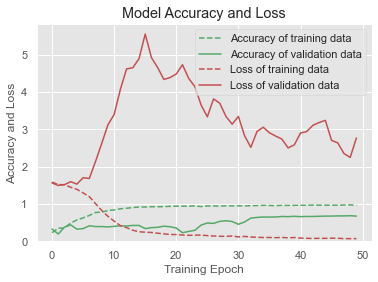

In [18]:
print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

#%%


--- Check against test data ---

87/87 [==============================] - 0s 149us/step

Accuracy on test data: 0.67

Loss on test data: 2.06

--- Confusion matrix for test data ---



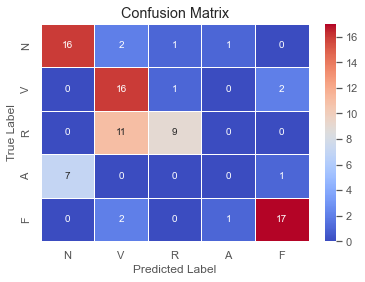


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.70      0.80      0.74        20
           1       0.52      0.84      0.64        19
           2       0.82      0.45      0.58        20
           3       0.00      0.00      0.00         8
           4       0.85      0.85      0.85        20

    accuracy                           0.67        87
   macro avg       0.58      0.59      0.56        87
weighted avg       0.66      0.67      0.64        87



In [21]:
print("\n--- Check against test data ---\n")

# Normalize features for training data set
df_test['II'] = feature_normalize(df_test['II'])

df_test = df_test.round({'II': 6})

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

# Set input_shape / reshape for Keras
x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype("float32")
y_test = y_test.astype("float32")

y_test = np_utils.to_categorical(y_test, num_classes)

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

# %%

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

# %%

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))